# Inducer binding analysis

In [4]:
import sys
import numpy as np
import pandas as pd
import pystan
import bokeh.io
import bokeh.plotting
import glob
sys.path.insert(0, '../../')
import mut.thermo
import mut.bayes
import mut.viz
import mut.stats
colors = mut.viz.pub_style()
bokeh.io.output_notebook()

Loading BokehJS ...

In [13]:
#  Load in all of the 2018 inducer data.
data_files =  glob.glob('../processing/2018*IND*/output/*.csv')
data = pd.concat([pd.read_csv(f, comment='#') for f in data_files], ignore_index=True)

# Remove Q294K and prune to reasonable fold-change values.
data = data[(data['mutant'] != 'Q294K') & (data['fold_change'] >= -0.2) & 
            (data['fold_change'] <= 1.3) & (data['repressors'] > 0)]

In [29]:
# Plot the leakiness.
leakiness = data[data['IPTGuM'] == 0]
grouped = leakiness.groupby(['mutant', 'repressors'])
color_dict = {'F164T': 'tomato', 'Q294V': 'dodgerblue', 'wt':'slategray'}

# Compute the theoretical curve.
rep_range = np.logspace(0, 4, 500)
epR = -13.9
arch = mut.thermo.SimpleRepression(rep_range, epR, ka=139E-6, ki=0.53E-6, ep_ai=4.5, n_sites=2,
                 effector_conc=0)
fc = arch.fold_change()

# Set up the figure canvas.
p = bokeh.plotting.figure(plot_width=600, plot_height=450, x_axis_type='log',
                         y_axis_type='log', x_axis_label= 'number of repressors',
                         y_axis_label = 'fold-change')


for g, d in grouped:
    err = d['fold_change'].std() / np.sqrt(len(d))
    p.circle(d['repressors'].mean(), d['fold_change'].mean(), color=color_dict[g[0]])
    p.line((g[1], g[1]), (d['fold_change'].mean() - err, d['fold_change'].mean() + err),
          color=color_dict[g[0]])



p.line(rep_range, fc)
bokeh.io.show(p)



In [34]:
# Plot the titration. 
p = bokeh.plotting.figure(plot_width=600, plot_height=400, x_axis_type='log',
                         x_axis_label='IPTG [µM]', y_axis_label='fold-change')

grouped = data.groupby(['mutant', 'IPTGuM'])

for g, d in grouped:
    err = d['fold_change'].std() / np.sqrt(len(d))
    mean_fc = d['fold_change'].mean()
    p.circle(g[1], mean_fc, color=color_dict[g[0]], legend=g[0])
    p.line((g[1], g[1]), (mean_fc - err, mean_fc + err), color=color_dict[g[0]])
   
p.legend.location = 'top_left'
bokeh.io.show(p)

##  Fitting Ka/Ki for mutants

In [35]:
def assemble_StanModelCode(model_file, function_file):
    """Returns a string of the stan model code from a model and function file"""
    lines = []
    files = [function_file, model_file]
    for f in files:
        with open(f, 'r') as file:
            out = file.read().splitlines()
            for line in out:
                lines.append(line) 
    model_code = """\n"""
    for line in lines:
        model_code += line + '\n'
    return model_code

In [141]:
# Load the stan model.
model_code = assemble_StanModelCode('../stan/heirarchical_kaki_fit.stan', '../stan/functions.stan')
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd50ef1538d785532edcd1869fbf84c NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpvdi8o3vs/stanfit4anon_model_acd50ef1538d785532edcd1869fbf84c_1050096888832529766.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpvdi8o3vs/stanfit4anon_model_acd50ef1538d785532edcd1869fbf84c_1050096888832529766.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [142]:
# Include an identifier.
idx = {'wt': 1, 'F164T': 2, 'Q294V':3}
idx_key = {1:'wt', 2:'F164T', 3:'Q294V'}
for i in idx.keys():
    data.loc[data['mutant'] == i, 'idx'] = idx[i]

# Assemble the data dictionary.
data_dict = {'J':3, 'N': len(data), 'trial': data['idx'].values.astype(int), 'epR': -13.9,
            'ep_ai': 4.5, 'R':260, 'n_sites':int(2), 'c':data['IPTGuM'], 'n_ns':4.6E6,
            'fc':data['fold_change']}


# Sample!
chains = sm.sampling(data=data_dict, iter=10000, chains=4)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [143]:
def chains_to_dataframe(fit):
    data = fit.extract()
    keys = list(data.keys())
    varnames = [k for k in keys if 'lp__' not in k]
    samples = {}
    for i, key in enumerate(varnames):
        # Get the shape.
        dim = np.shape(data[key])
        if len(dim) == 2:
            for j in range(dim[-1]):
                samples['{}.{}'.format(key, j+1)] = data[key][:, j]
    
        else:
            samples[key] = data[key]
            
    # compute the log_post. 
    new_keys = samples.keys()
    logp = []
    for j in range(dim[0]):
        logp.append(fit.log_prob([samples[k][j] for k in samples.keys()], adjust_transform=False))
        
    samples['logp'] = logp
    return pd.DataFrame(samples)
    

In [144]:
sampling_df = chains_to_dataframe(chains)
new_cols = {'{}.{}'.format(v.split('.')[0], i+1) : '{}_{}'.format(v.split('.')[0], idx_key[i+1]) for i in range(3) for v in chains.unconstrained_param_names()}
sampling_df.rename(columns=new_cols, inplace=True)
stats = mut.stats.compute_statistics(sampling_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


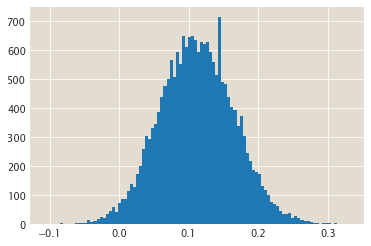

In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
_ = plt.hist(sampling_df['ki_wt'], bins=100)

In [146]:
chains.flatnames?

In [138]:
chains.extract()

OrderedDict([('ka', array([[190.7345526 ,  43.27938352,   6.29541332],
                     [ 26.22295152,  10.20761947,   6.46132451],
                     [ 82.05089211,  25.41503933,   6.82572578],
                     ...,
                     [100.53726479,  26.94642973,   6.64939875],
                     [226.4266518 ,  52.65441153,   6.46059247],
                     [  6.9404378 , 162.42039952,   6.01811759]])),
             ('ki', array([[1.03363857e-01, 6.17038353e-02, 1.30447415e+00],
                     [7.43555128e-02, 1.50899530e-02, 1.24570954e+00],
                     [1.22978427e-01, 5.34196892e-03, 1.45860287e+00],
                     ...,
                     [6.91618335e-02, 4.91378121e-05, 1.33404162e+00],
                     [5.54375824e-02, 6.55376753e-03, 1.28559336e+00],
                     [1.02019467e-02, 5.48600148e-02, 9.96668219e-01]])),
             ('sigma', array([[0.09463915, 0.1590509 , 0.11800334],
                     [0.10373982, 0.13679614, 

In [139]:
sampling_df['logp'].idxmax(axis=1, skipna=True)


1970

In [140]:
p = bokeh.plotting.figure(plot_width=400, plot_height=400, x_axis_type='log',
                         x_axis_label='IPTG [µM]', y_axis_label='fold-change')

c_range = np.logspace(-2, 4, 500)
for i, m in enumerate(idx.keys()):
    
    # Isolate the parameters
    ka = stats[stats['parameter']== 'ka_{}'.format(m)].values[0][1:]
    ki = stats[stats['parameter']== 'ki_{}'.format(m)].values[0][1:]

    # Set up the architecture and plot the best-fit.
    arch = mut.thermo.SimpleRepression(260, -13.9, ep_ai=4.5, effector_conc=c_range, 
                                      ka=ka[0], ki=ki[0], n_sites=2).fold_change()
    
    # Plot the predictions.
    p.line(c_range, arch, color=color_dict[m], legend=m)
    bandx = np.append(c_range, c_range[::-1])

    
    # Plot the data on top.
    d = data[data['mutant'] == m]
    grouped = d.groupby(['IPTGuM'])
    for g, _d in grouped:
        mean_fc = _d['fold_change'].mean()
        err_fc = _d['fold_change'].std() / np.sqrt(len(d))
        p.circle(g, mean_fc, color=color_dict[m])
        p.line((g, g), (mean_fc - err, mean_fc + err), color=color_dict[m])
p.legend.location = 'top_left'
bokeh.io.show(p)

In [80]:
stats[stats['parameter']=='ka_wt'].values[0][1:]

array([110.31683120380619, 180.08827504087307, 357.0242099938354],
      dtype=object)